In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense,GRU
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestRegressor


In [72]:
df = pd.read_excel("trial.xlsx",sheet_name='Raw data',index_col=None)

df=df.iloc[:, [0, 1, 4,5,6,7,8,9,10,11,12,18,21,29,30,31,41,42,43]]
df=df.iloc[:,[0,1,2,3,4,9]]
# df.set_index('Date',inplace=True)


for col in df.columns:
    # count the number of NaN values in the column
    num_nan = df[col].isna().sum()
    
    # print the column name and the number of NaN values
    print(f"Column '{col}' has {num_nan} NaN values.")
len(df)
# df=df.dropna()

#filling nans
# fill_methods = {'Turkey_import': 0, 'Brazil_import': 0}

# fill NaN values using specified methods for each column
# df.fillna(value=fill_methods, inplace=True)


Column 'Date' has 0 NaN values.
Column 'Domestic Market (Contract) Blow Molding, Low' has 0 NaN values.
Column 'WTISPLC' has 0 NaN values.
Column 'MCOILBRENTEU' has 0 NaN values.
Column 'GASREGM' has 0 NaN values.
Column 'PCU325211325211' has 1 NaN values.


276

In [63]:
df = df.rename(columns={'Producer Price Index by Industry: Plastics Material and Resins Manufacturing: Thermoplastic Resins and Plastics Materials ': 'PPI(Thermoplastic)'})
df = df.rename(columns={'Domestic Market (Contract) Blow Molding, Low': 'DMBM,low'})



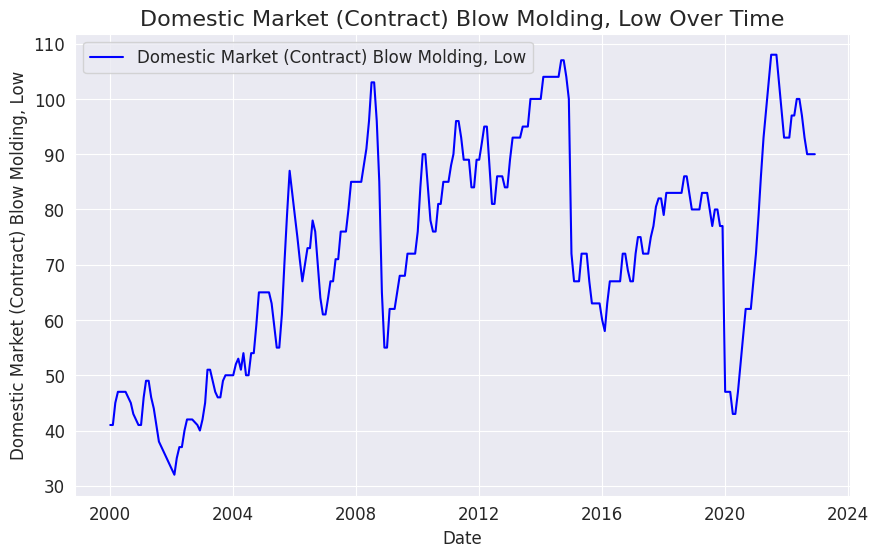

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style to seaborn
sns.set_style('darkgrid')

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df.values[:,0],df.values[:,1], label='Domestic Market (Contract) Blow Molding, Low', color='blue')

# Set the x-axis label
ax.set_xlabel('Date', fontsize=12)

# Set the y-axis label
ax.set_ylabel('Domestic Market (Contract) Blow Molding, Low', fontsize=12)

# Set the title
ax.set_title('Domestic Market (Contract) Blow Molding, Low Over Time', fontsize=16)

# Add a legend
ax.legend(fontsize=12)

# Increase the font size of the tick labels
ax.tick_params(axis='both', which='major', labelsize=12)
plt.savefig('Target_timeseries.png')
plt.show()


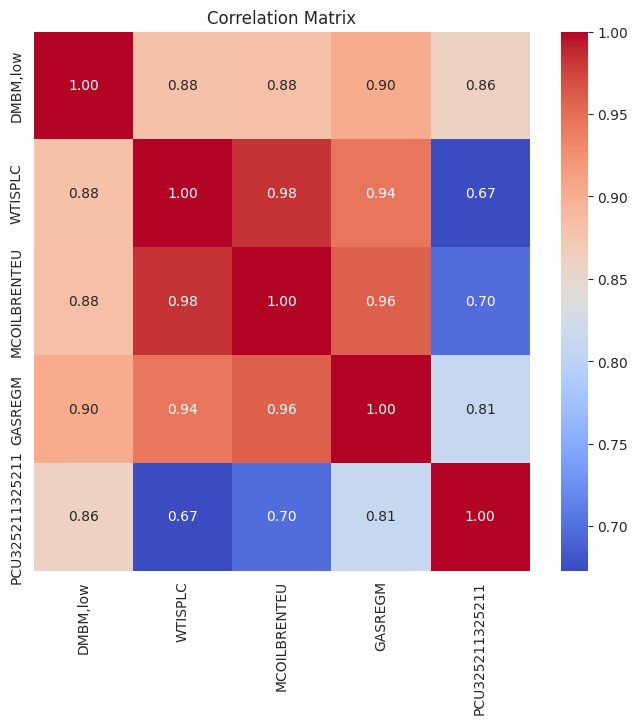

In [65]:
import pandas as pd
import seaborn as sns


corr_matrix = df.iloc[:,1:].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix_sig')
plt.show()

<ipython-input-66-89144cc4abb3>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = features.corr()


DMBM,low           1.000000
GASREGM            0.902080
MCOILBRENTEU       0.881459
WTISPLC            0.880024
PCU325211325211    0.860728
Name: DMBM,low, dtype: float64


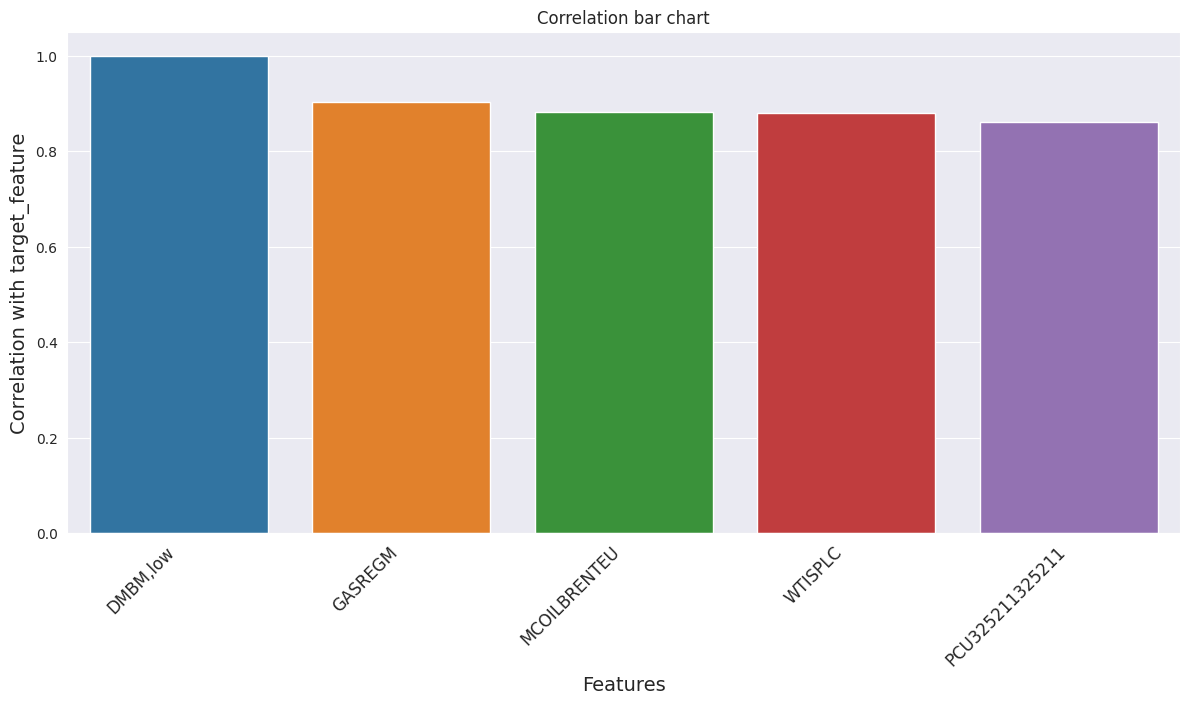

In [66]:
import pandas as pd
import seaborn as sns

def correl_bar(features,target_key):

  corr_matrix = features.corr()

  corr_with_y = corr_matrix.loc[target_key]

  corr_with_y_sorted = corr_with_y.sort_values(ascending=False)

  print(corr_with_y_sorted)

  fig, ax = plt.subplots(figsize=(12, 8))
  sns.barplot(x=corr_with_y_sorted.index, y=corr_with_y_sorted.values, ax=ax)
  ax.set_xticklabels(corr_with_y_sorted.index, rotation=45, fontsize=12, ha='right')
  ax.set_ylabel('Correlation with target_feature', fontsize=14)
  ax.set_xlabel('Features', fontsize=14)
  plt.title('Correlation bar chart', fontsize=16, pad=20)  
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  

  plt.title('Correlation bar chart')
correl_bar(df,'DMBM,low')
plt.savefig('correlation_bar.png')

#Models

In [83]:
#LSTM MODEL
def data_process(feature,target,date,jump=6,split_set=0.8):

  from sklearn.preprocessing import StandardScaler
  
  n=int(split_set*len(feature))
  df2_train=feature.iloc[:n] #feature_train_set
  x=np.reshape(df2_train.values,(n,1))
  print(len(df2_train))
  df2_train.head()
  df2_train_y=target.iloc[:n] #target train set
  df2_test=feature.iloc[n:] #feature test set
  df2_test_y=target.iloc[n:] #feature test set

  sc=StandardScaler()
  sc2=StandardScaler()

  x=np.reshape(df2_train.values,(n,1))
  df2_train_scaled=sc.fit_transform(x)
  df2_train_scaled
  print(df2_train_scaled.shape)
  y=np.reshape(df2_train_y.values,(n,1))
  df2_train_scaled_y=sc2.fit_transform(y)
  df2_train_scaled_y
  print(df2_train_scaled_y.shape)
  X_train=[]
  y_train=[]
  for i in range(jump,n):
    X_train.append(df2_train_scaled[i-jump:i])
    y_train.append(df2_train_scaled_y[i][0])
  X_train,y_train=np.array(X_train),np.array(y_train)
  print(X_train.shape)
  print(y_train.shape)
  X_train_shape=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],X_train.shape[2]))
  X_train_shape.shape
  
  df1_train_last12=df2_train.iloc[-jump:]
  df1_test_full=df2_test

  full_df=pd.concat((df1_train_last12,df1_test_full),axis=0)
# print(full_df.shape)
# full_df.head()
  full_x=np.reshape(full_df.values,(len(full_df),1))
  full_df=sc.transform(full_x)
  X_train_shape_pred=[]
  Y_test1=[]
  for i in range(jump,full_df.shape[0]):
    X_train_shape_pred.append(full_df[i-jump:i])
    Y_test1.append(full_df[i][0])

  X_train_shape_pred=np.array(X_train_shape_pred)
  Y_test1=np.array(Y_test1)
  Y_test1=np.reshape(Y_test1,(len(Y_test1),1))
  y_test1=sc2.inverse_transform(Y_test1)
  date_end=date.iloc[-len(y_test1):]
  return X_train_shape,y_train,X_train_shape_pred,df2_test_y,date_end,sc2 #y_test1 in inverse form everything else transformed

def lstmmodel(feature,target,date,jump=6,split_set=0.8,epochs=10):
  train_setx,train_sety,test_setx,y_test,date_end,sc2=data_process(feature,target,date,jump,split_set)
  from keras.models import Sequential
  from keras.layers import Dense, LSTM, Dropout
  model = Sequential()
  model.add(LSTM(50, input_shape=(train_setx.shape[1],1)))
  model.add(Dense(1, activation='linear'))

  # Compile the model
  model.compile(loss='mean_squared_error', optimizer='adam')
  # model=Sequential()
  # model.add(LSTM(units=50,return_sequences=True,input_shape=(12,5)))
  # model.add(Dropout(0.2))
  # model.add(LSTM(units=50))
  # model.add(Dropout(0.2))
  # model.add(Dense(1))
  # model.compile(optimizer='adam',loss='mean_squared_error')
  model.fit(train_setx,train_sety,epochs=epochs,batch_size=32)
  ypred=model.predict(test_setx)
  print(ypred)
  y_final_pred=sc2.inverse_transform(ypred)
  y_final_pred

  return y_final_pred,y_test,date_end
def grumodel(feature,target,date,jump=6,split_set=0.8,epochs=10):
  train_setx,train_sety,test_setx,y_test,date_end,sc2=data_process(feature,target,date,jump,split_set)
  from keras.models import Sequential
  from keras.layers import Dense, LSTM, Dropout
  model = Sequential()
  model.add(GRU(50, input_shape=(train_setx.shape[1],1)))
  model.add(Dense(1, activation='linear'))

  # Compile the model
  model.compile(loss='mean_squared_error', optimizer='adam')
  # model=Sequential()
  # model.add(LSTM(units=50,return_sequences=True,input_shape=(12,5)))
  # model.add(Dropout(0.2))
  # model.add(LSTM(units=50))
  # model.add(Dropout(0.2))
  # model.add(Dense(1))
  # model.compile(optimizer='adam',loss='mean_squared_error')
  model.fit(train_setx,train_sety,epochs=epochs,batch_size=32)
  ypred=model.predict(test_setx)
  print(ypred)
  y_final_pred=sc2.inverse_transform(ypred)
  y_final_pred
  lastday=test_setx[-1]
  lastday=lastday[-1]
  lastday
  return y_final_pred,y_test,date_end

#RandomForestRegressor Model
def data_process_rf(feature,target,date,split_set=0.6):

  n=int(len(target)*split_set)
  X=[]
  Y=[]
  print(len(df)-6)
  for i in range(6,len(feature)):
  # print(i,i+6)
    X.append(feature.iloc[i-6:i])
    print(i,target.iloc[i])
    Y.append(target.iloc[i])
  print('complete')
  X=np.array(X)
  Y=np.array(Y)
  X_train=X[:n]
  Y_train=Y[:n]

  X_test=X[n:]
  Y_test=Y[n:]
  date_end=date.iloc[-len(Y_test):]

  return X_train, Y_train,X_test,Y_test,date_end

def rf_model(feature,target,date):
  from sklearn.ensemble import RandomForestRegressor

  X_train,Y_train,X_test,Y_test,date_end=data_process_rf(feature,target,date)

  rf = RandomForestRegressor(n_estimators=70,max_depth=18)
  rf.fit(X_train, Y_train)
  y_pred = rf.predict(X_test)
  return y_pred,Y_test,date_end

#errors
def errors(actual,prediction):
  y_test=actual
  y_final_pred=prediction
  rmse_lstm = np.sqrt(mean_squared_error(y_test, y_final_pred))
  mse_lstm = mean_squared_error(y_test, y_final_pred)
  r2_lstm = r2_score(y_test, y_final_pred)
  return np.round(rmse_lstm,2),np.round(mse_lstm,2),np.round(r2_lstm,2)
  # return print(f'rmse,mse,r2: {rmse_lstm,mse_lstm,r2_lstm}')


# Data load
calling separately as the sizes vary

In [10]:
df1=df.iloc[:,[0,1,2]].dropna()
df2=df.iloc[:,[0,1,3]].dropna()
df3=df.iloc[:,[0,1,4]].dropna()
df4=df.iloc[:,[0,1,5]].dropna()
df5=df.iloc[:,[0,1,6]].dropna()
# df6=df.iloc[:,[0,1,7]].dropna()
# df7=df.iloc[:,[0,1,8]].dropna()
# df8=df.iloc[:,[0,1,9]].dropna()
# df9=df.iloc[:,[0,1,-2]].dropna()
# df10=df.iloc[:,[0,1,-2]].dropna()
# df10=df.iloc[:,[0,1,-1]].dropna()


# LSTM RESULTS

In [ ]:
df.shape

(276, 19)

In [ ]:
all=[]
for i in range(2,df.shape[1]):
  df1=df.iloc[:,[0,1,i]].dropna()
  predicted,actual,date_end=lstmmodel(df1.iloc[:,2],df1.iloc[:,1],df1['Date'],epochs=50,split_set=0.6)
  all.append((predicted,actual,date_end))


WTISPLC:
(13.87, 192.43, -0.34)
MCOILBRENTEU:
(12.98, 168.57, -0.5)
GASREGM:
(11.52, 132.76, -0.55)
PCU325211325211:
(16.37, 268.06, -3.28)


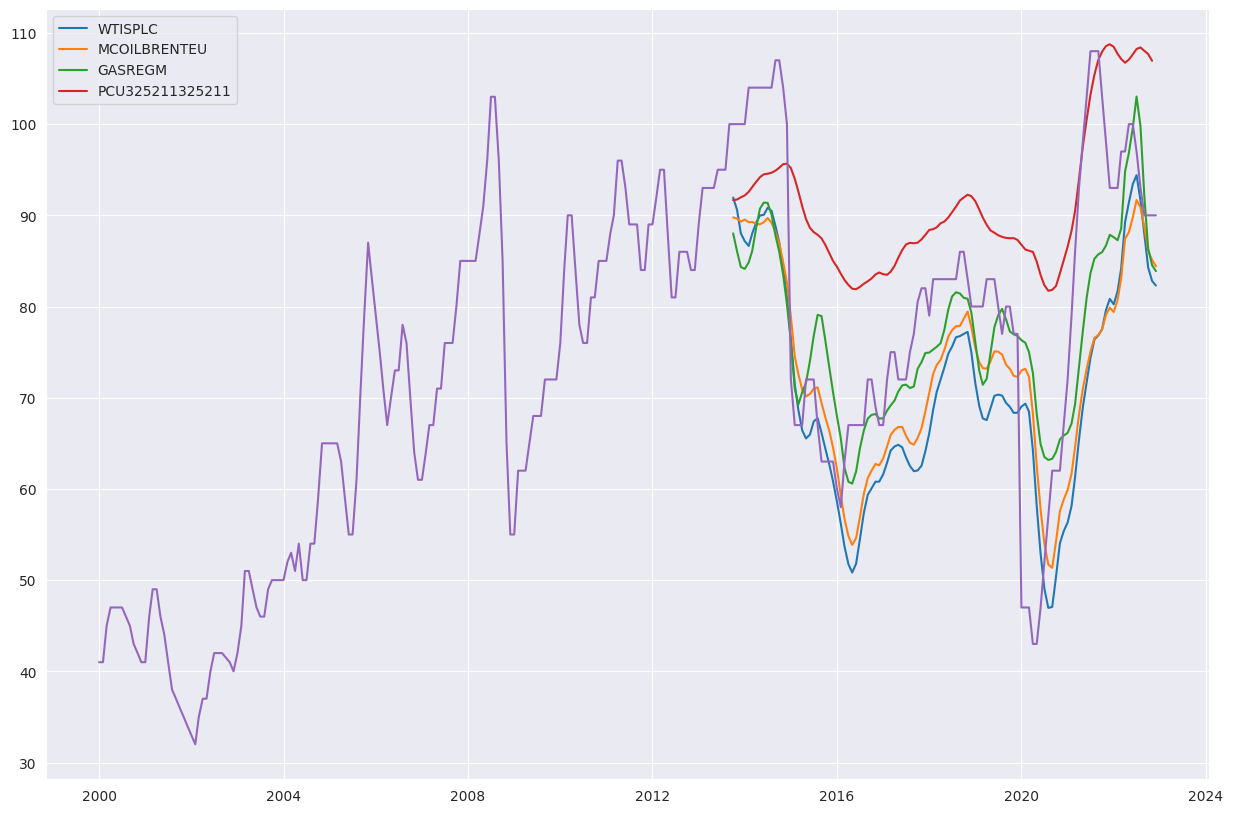

In [84]:
all=np.array(all)
all[0].shape
plt.figure(figsize=(15,10))
error_table=[]
for i in range(0,len(all)):
  a,b,c=all[i]
  error_table.append((df.columns[i+2],*errors(a, b)))
  print(f'{df.columns[i+2]}:\n{errors(a, b)}')

  plt.plot(c,a,label=df.columns[i+2])
plt.plot(df.iloc[:,0],df.iloc[:,1])
plt.legend()


In [94]:
dft=pd.DataFrame(error_table)
dft.columns=['Feature','rmse','mse','r2']
# dft.to_csv('tab.csv',index=False)
dft

,Feature,rmse,mse,r2
0,WTISPLC,13.87,192.43,-0.34
1,MCOILBRENTEU,12.98,168.57,-0.50
2,GASREGM,11.52,132.76,-0.55
3,PCU325211325211,16.37,268.06,-3.28


[<Axes: > <Axes: > <Axes: > <Axes: >]


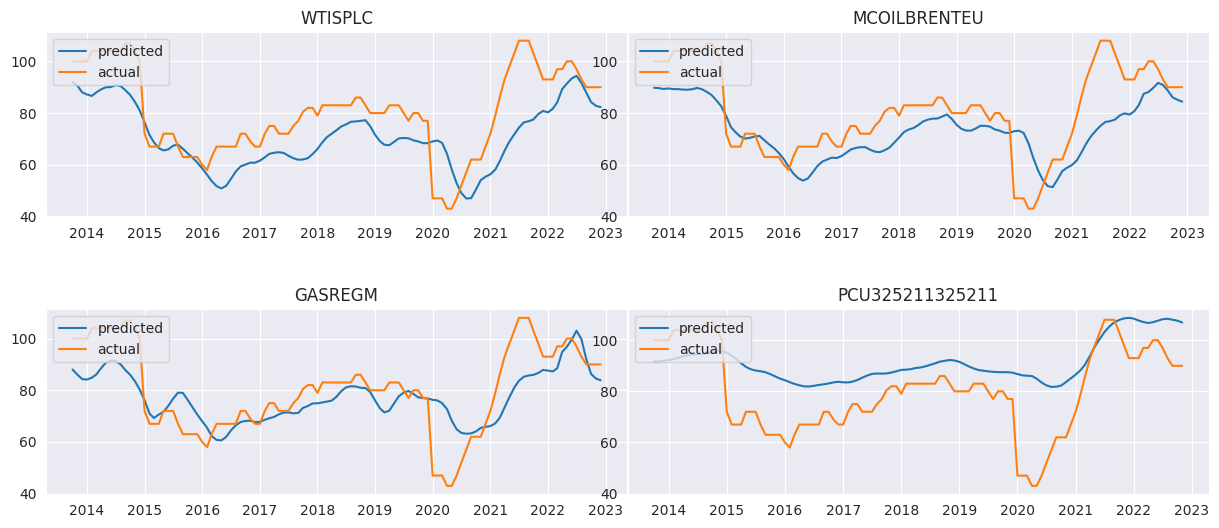

In [73]:
fig, axs = plt.subplots(2,2, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
# axs.legend()
axs = axs.ravel()
print(axs)
for i in range(0,len(all)):
  a,b,c=all[i]
  axs[i].plot(c,a,label='predicted')
  axs[i].plot(c,b,label='actual')
  axs[i].set_title(df.columns[i+2])
  axs[i].legend(loc='upper left')

  # axs[i].flatten().legend()
  # error_table.append((df.columns[i+2],*errors(a, b)))
  # print(f'{df.columns[i+2]}:\n{errors(a, b)}')



GRU

In [95]:
all1=[]
for i in range(2,df.shape[1]):
  df11=df.iloc[:,[0,1,i]].dropna()
  predicted,actual,date_end=grumodel(df11.iloc[:,2],df11.iloc[:,1],df11['Date'],epochs=50,split_set=0.6)
  all1.append((predicted,actual,date_end))


165
(165, 1)
(165, 1)
(159, 6, 1)
(159,)
Epoch 1/50
5/5 [==============================] - 5s 11ms/step - loss: 1.3698
Epoch 2/50
5/5 [==============================] - 0s 8ms/step - loss: 1.0848
Epoch 3/50
5/5 [==============================] - 0s 7ms/step - loss: 0.8434
Epoch 4/50
5/5 [==============================] - 0s 8ms/step - loss: 0.6336
Epoch 5/50
5/5 [==============================] - 0s 9ms/step - loss: 0.4677
Epoch 6/50
5/5 [==============================] - 0s 9ms/step - loss: 0.3212
Epoch 7/50
5/5 [==============================] - 0s 8ms/step - loss: 0.2242
Epoch 8/50
5/5 [==============================] - 0s 15ms/step - loss: 0.1653
Epoch 9/50
5/5 [==============================] - 0s 12ms/step - loss: 0.1465
Epoch 10/50
5/5 [==============================] - 0s 11ms/step - loss: 0.1444
Epoch 11/50
5/5 [==============================] - 0s 11ms/step - loss: 0.1382
Epoch 12/50
5/5 [==============================] - 0s 12ms/step - loss: 0.1275
Epoch 13/50
5/5 [=========

WTISPLC:
(13.87, 192.43, -0.34)
MCOILBRENTEU:
(12.98, 168.57, -0.5)
GASREGM:
(11.52, 132.76, -0.55)
PCU325211325211:
(16.37, 268.06, -3.28)


<ipython-input-96-49eea26395ed>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all1=np.array(all1)


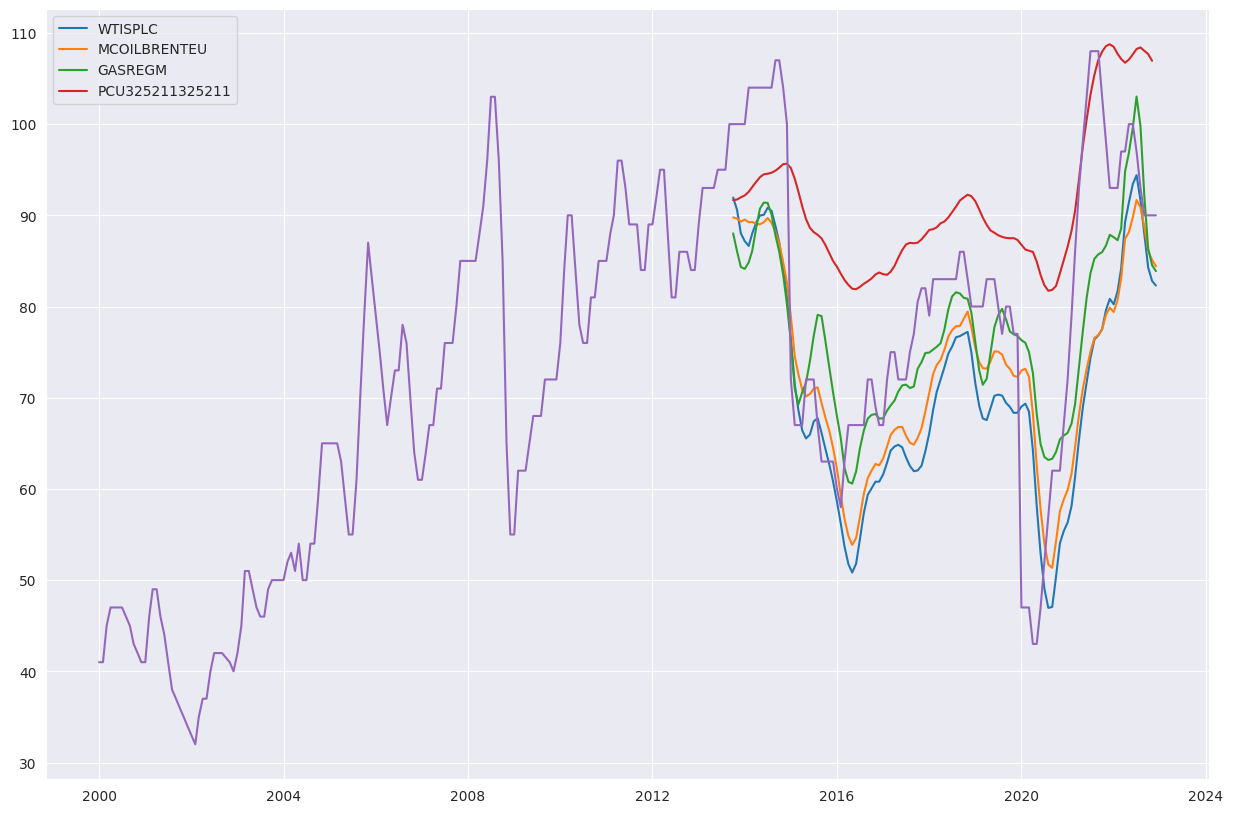

In [96]:
all1=np.array(all1)
all1[0].shape
plt.figure(figsize=(15,10))
error_table=[]
for i in range(0,len(all1)):
  a,b,c=all[i]
  error_table.append((df.columns[i+2],*errors(a, b)))
  print(f'{df.columns[i+2]}:\n{errors(a, b)}')

  plt.plot(c,a,label=df.columns[i+2])
plt.plot(df.iloc[:,0],df.iloc[:,1])
plt.legend()


In [97]:
dft=pd.DataFrame(error_table)
dft.columns=['Feature','rmse','mse','r2']
# dft.to_csv('tab.csv',index=False)
dft

,Feature,rmse,mse,r2
0,WTISPLC,13.87,192.43,-0.34
1,MCOILBRENTEU,12.98,168.57,-0.50
2,GASREGM,11.52,132.76,-0.55
3,PCU325211325211,16.37,268.06,-3.28
